# Intro

This notebook tests the functions of single unit plotting to plot one session's rates and rasters

---
# Setup

In [1]:
##% imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from time import time

from popy.io_tools import load_behavior, load_neural_data
from popy.behavior_data_tools import add_value_function, drop_time_fields
from popy.neural_data_tools import *
from popy.plotting.plotting_tools import plot_keypoints

# fontsizes 8
plt.rcParams.update({'font.size': 8})


In [2]:
##% data tools
def get_data(monkey, session, mode='full_trial', n_extra_trials=(0, 0)):
    #neural_data = get_data(monkey, session, n_extra_trials=n_extra_trials)

    # get behavior data
    behav = load_behavior(monkey, session)
    #behav = add_value_function(behav, monkey=monkey, digitize=True, n_classes=4) # add value function
    behav = add_value_function(behav, digitize=True, n_classes=4) # add value function
    behav['next_target'] = behav['target'].shift(-1)  # shift the target by 1
    behav['feedback_t-1'] = behav['feedback'].shift(1)  # shift the feedback by 1
    behav['feedback_t-2'] = behav['feedback'].shift(2)  # shift the feedback by 1
    behav['feedback_t-3'] = behav['feedback'].shift(3)  # shift the feedback by 1
    # shift the value function by 1
    behav = drop_time_fields(behav)  

    # get neural data
    neural_data = load_neural_data(monkey, session, hz=1000)  # load neural data
    neural_data = remove_trunctuated_neurons(neural_data, mode='set_nan', delay_limit=20, print_usr_msg=True)  # set indices to nan

    neural_data = add_firing_rates(neural_data, 'gauss')  # add firing gauss
    neural_data = downsample_time(neural_data, 100)  # downsample neural data
    #neural_data = time_normalize_session(neural_data)  # normalize neural data in time
    
    # build dataset
    if mode == 'full_trial':
        neural_dataset = build_trial_dataset(neural_data, mode='full_trial', n_extra_trials=n_extra_trials)
    elif mode == 'centering':
        neural_dataset = build_trial_dataset(neural_data, mode='centering', center_on_epoch_start=5, center_window=(-3, 3))

    print(f'Built dataset, shape:')
    neural_dataset = merge_behavior(neural_dataset, behav)  # merge behavior and neural data

    return neural_data, neural_dataset
    
        
def add_mixed_coord(neural_data_original, groupped_by):
    '''
    Removes all the coords from the neural_data except the trial_id, and adds a new coord along the trials dimension. Only the 
    coords to plot will rest in the neural_data.

    E.g. groupped_by = 'value * target' -> under each target, look at the value levels.
    
    '''
    neural_data = neural_data_original.copy()
    
    groupped_by = groupped_by.split(' * ')

    if len(groupped_by) == 1:
        primary_labels = neural_data.coords[groupped_by[0]].data  # e.g. a vector of the value levels per trial
        neural_data.coords[f'*{groupped_by[0]}'] = ('trial_id', primary_labels)
        return neural_data
        
    elif len(groupped_by) == 2:
        '''
        E.g. groupped_by = 'value * target' -> under each target, look at the value levels.
        '''    
        
        # get the 
        primary_labels = neural_data.coords[groupped_by[0]].data  # e.g. a vector of the value levels per trial
        secondary_labels = neural_data.coords[groupped_by[1]].data  # e.g. a vector of the selected targets per trial
                
        # add new coord along the trials dimension
        unique_secondary_labels = np.unique(secondary_labels)  # e.g. the unique targets
        unique_secondary_labels = unique_secondary_labels[~np.isnan(unique_secondary_labels)]  # remove nans
        for secondary_label in unique_secondary_labels:
            coord_name = f'*{groupped_by[0]} | {groupped_by[1]}={str(secondary_label)}'  # e.g. target_1_value
            coord_values = [primary if secondary == secondary_label else np.nan for primary, secondary in zip(primary_labels, secondary_labels) ]
            neural_data.coords[coord_name] = ('trial_id', coord_values)
            print(f'Added coord {coord_name}, length: {len(coord_values)}')
        
    return neural_data
    
        


In [3]:
##% plotting tools

COLORS_value= [
    '#779ECC',  # Dark Pastel Blue
    '#9FC0DE',  # Pale Cerulean
    '#F2C894',  # Peach-Orange
    '#FFB347',  # Pastel Orange
    '#FF985A'   # Atomic Tangerine
]

COLORS_feedback = [
    'tab:red',
    'tab:green',
]


def plot_spike_trains(neural_data, monkey, session):
    plt.imshow(neural_data.spike_trains, aspect='auto', cmap='Grays', interpolation='none')
    ylabel = [f'{unit}' for unit in neural_data.unit.values]
    xlabel = neural_data.time.values
    plt.yticks(np.arange(len(ylabel)), ylabel, fontsize=5)
    #plt.xticks(np.arange(0, len(xlabel), 100000), xlabel[::100000])

    # add lables and legend: white horizontal bar is no recording, black is recording
    plt.plot([0, 0], [0, 0], color='black', label='Recording', linewidth=5)
    plt.plot([0, 0], [0, 0], color='white', label='No recording', linewidth=5)
    plt.legend(loc='upper right')

    plt.grid(alpha=.2)

    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons')
    plt.title(f'{monkey}_{session}')
    plt.show()

def plot_rates_with_raster(
    neural_data_original, 
    unit_name, 
    mode='full_trial',  # 'full_trial' or 'centering'
    n_extra_trials=(0, 0),  # number of extra trials to plot (in case of full_trial)
    title=None,
    time_window=None,  # time window to plot (relative to the time of the data)
    color_palette=None,  # color palette to use, 'feedback' or 'value'
    show_raster=True,
    ):    
    '''
    Plot the raster plot and the firing rate of a unit, for each value level of the coord_names.
    
    Parameters
    ----------
    neural_data : xarray.Dataset
        The neural data.
    unit_name : str
        The name of the unit to plot.
    n_extra_trials : touple, optional
        The number of extra trials to plot. The default is (0, 0).
    title : str, optional
        The title of the plot. The default is None.
    time_window : tuple, optional
        The time window to plot. The default is None.

    Returns
    ------- 
    fig : matplotlib.figure.Figure
        The figure.
    axs : matplotlib.axes.Axes
        The axes.
    '''
    if color_palette == 'feedback':
        COLORS_temp = COLORS_feedback
    elif color_palette == 'value':
        COLORS_temp = COLORS_value
    else:
        COLORS_temp = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
        
    neural_data = neural_data_original.copy()
    neural_data = neural_data.sel({'unit': unit_name})  # select the unit of interest

    # get the coord names of interest and determine the number of plots to make
    coord_names = [coord_name for coord_name in neural_data.coords if coord_name[0] == '*']  # get the coord names of interest
    n_plots = len(coord_names)
    
    # Create figure and axes with no space between rows
    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(10*cm*n_plots, 10*cm))
    gs = fig.add_gridspec(2, n_plots, height_ratios=[1, 1], hspace=0)

    # Create axes arrays with shared axes
    axs = [[None for j in range(n_plots)] for i in range(2)]
    
    # First create the leftmost column
    axs[0][0] = fig.add_subplot(gs[0, 0])  # Top left
    axs[1][0] = fig.add_subplot(gs[1, 0], sharex=axs[0][0])  # Bottom left
    plt.setp(axs[0][0].get_xticklabels(), visible=False)  # Hide only the tick labels, keep ticks

    # Then create the rest sharing both x and y axes
    for j in range(1, n_plots):
        axs[0][j] = fig.add_subplot(gs[0, j], sharex=axs[0][0], sharey=axs[0][0])  # Top row
        axs[1][j] = fig.add_subplot(gs[1, j], sharex=axs[0][0], sharey=axs[1][0])  # Bottom row
        plt.setp(axs[0][j].get_xticklabels(), visible=False)  # Hide only the tick labels, keep ticks

    if not title is None:
        plt.suptitle(title)

    for i, coord_name in enumerate(coord_names):
        # get the variable and the conditions
        variable = coord_name.split(' | ')[0][1:]
        condition = coord_name.split(' | ')[1] if len(coord_name.split(' | ')) > 1 else None

        if variable == 'feedback':
            COLORS_temp = COLORS_feedback
        elif variable == 'value_function':
            COLORS_temp = COLORS_value
        else:
            COLORS_temp = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

        unique_labels = np.unique(neural_data[coord_name].data)  # get the unique labels of all of the coords of interest
        unique_labels = unique_labels[~np.isnan(unique_labels)]  # remove nans
        
        colors = {str(label): COLORS_temp[i] for i, label in enumerate(unique_labels)}  # color for each value level

        # prepare the data (sort trials by the coord_name, drop trials with nan labels)
        neural_data_temp = _prepare_data(neural_data, coord_name)

        time_vector = neural_data_temp.coords['time'].data  # get the time vector and the trial labels

        # plot raster with extent of x=time_vector and y=trial_labels
        ax_raster = axs[0][i] if n_plots > 1 else axs[0][0]

        
        # Plot colored spikes
        if show_raster:
            # Convert spike trains to x,y coordinates
            spikes = np.where(neural_data_temp.spike_trains)
            trial_ids = spikes[0]
            spike_times = time_vector[spikes[1]]

            # Get colors for each spike based on trial type
            trial_colors = [colors[str(neural_data_temp[coord_name].sel(trial_id=neural_data_temp.trial_id.data[tid]).data)] for tid in trial_ids]  # get the color of the trial

            ax_raster.scatter(spike_times, trial_ids, marker='|', c=trial_colors, s=2.5, linewidth=0.6)

        # settings
        if condition is None:
            ax_raster.set_title(f'CODING OF: {variable}')
        else:
            ax_raster.set_title(f'CODING OF: {variable}' + f'\nCONDITION: {condition}')
            
        ax_raster.set_ylabel('')
        '''ax_raster.set_xlabel('')  # remove x label from the raster plot
        ax_raster.set_xticks([])  # remove y ticks'''
        ax_raster.set_yticks([])  # remove y ticks
        #ax_raster.legend(title=f'{coord_name.split("--")[0][1:]}', loc='center left', bbox_to_anchor=(1, 0.5))
        ax_raster.spines['bottom'].set_visible(False)

        # plot firing rate (that is the mean spike count) by value level
        ax_rate = axs[1][i] if n_plots > 1 else axs[1][0]
        unique_labels_temp = np.unique(neural_data_temp[coord_name].data)  # set background color based on value level
        for label_temp in unique_labels_temp:
            curr_coord_ids = np.where(neural_data_temp[coord_name].data == label_temp)[0]  # get the non-nan indices
            curr_coord_trials = neural_data_temp.trial_id.data[curr_coord_ids]
            neural_data_currvalue = neural_data_temp.sel({'trial_id': curr_coord_trials})  # further select only the interesting units
            # rolling window spike count mean
            mean_rate = np.mean(neural_data_currvalue.firing_rates, axis=0)

            ax_rate.plot(time_vector, mean_rate, label=f'{label_temp}', color=colors[str(label_temp)])
            
        ax_rate.set_ylabel('Firing rate (Hz)')
        ax_rate.set_xlabel('Time from feedback (s)')
        ax_rate.legend(title=variable, frameon=False, loc='upper right')
        # settings
        for ax in [ax_raster, ax_rate]:
            if mode == 'full_trial':
                plot_keypoints(ax, n_extra_trials=n_extra_trials)  # plot the extra trials
                ax.grid(axis='x', alpha=.8, color='grey', linestyle='--')
            elif mode == 'centering':
                ax.axvline(0, color='black', lw=.7)  # plot the centering line
    

            if time_window is None:
                ax.set_xlim(time_vector[0], time_vector[-1])
            else:
                ax.set_xlim(*time_window)
            # remove spines
            for spine in ['right', 'top']:
                ax.spines[spine].set_visible(False)


    plt.tight_layout()

    return fig, axs


def _prepare_data(neural_data, coord_name):
        neural_data_temp = neural_data.copy()
        
        # get only the trials where the coord_name is not nan, and sort them
        non_nan_coord_ids = np.where(~np.isnan(neural_data_temp[coord_name].data))[0]  # get the non-nan indices
        non_nan_coord_trials = neural_data_temp.trial_id.data[non_nan_coord_ids]  # get the non-nan trials
        non_nan_coord_labels = neural_data_temp[coord_name].data[non_nan_coord_ids]  # get the non-nan labels
        non_nan_coord_trials = non_nan_coord_trials[np.argsort(non_nan_coord_labels)]  # sort the trials by the labels
        neural_data_temp = neural_data_temp.sel({'trial_id': non_nan_coord_trials})  # remove nan values (nan coordinates) and sort the trials by the labels

        # get only tials where the neural activity has no nan values - THIS SHOULD BE DONE BEFORE PASSING THE DATA TO THE PLOTTING FUNCTION
        """non_nan_ids = np.where(~np.isnan(neural_data_temp.spike_trains.data).all(axis=1))[0]
        non_nan_trials = neural_data_temp.trial_id.data[non_nan_ids]
        neural_data_temp = neural_data_temp.sel({'trial_id': non_nan_trials})"""  # remove nan values (nan neural activity)
    
        return neural_data_temp

---
# Load data

In [4]:
monkey, session = 'ka', '230720'
n_extra_trials = (0, 0)

In [5]:
neural_data, neural_dataset = get_data(monkey, session, mode='centering')

neural_data

Set to NaN 4/15 units with trunctuated recordings, delay limit: 20 s.
 Invalid units: {'LPFC_06_03', 'LPFC_07_02', 'LPFC_06_02', 'LPFC_08_03'}
Built dataset, shape:


<xarray.Dataset>
Dimensions:           (unit: 15, time: 178570)
Coordinates:
  * unit              (unit) object 'LPFC_05_01' 'LPFC_06_01' ... 'MCC_15_01'
  * time              (time) float64 9.22 9.23 9.24 ... 1.795e+03 1.795e+03
    unit_id_original  (unit) int64 67 71 97 96 15 98 99 73 76 78 21 75 72 77 81
    channel           (unit) int64 5 6 6 6 7 7 7 8 8 8 6 9 10 10 15
    monkey            (unit) object 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka'
    session           (unit) object '230720' '230720' ... '230720' '230720'
    area              (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    subregion         (unit) object 'dLPFC' 'dLPFC' 'dLPFC' ... 'MCC' 'MCC'
    trial_id          (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    epoch_id          (time) float64 nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    spike_trains      (unit, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    firing_rates      (unit, time) float32 0.0 0.0 0.0 ... 0.0009563 0.0003898
Attributes:
    bin_size:  0.01

---
# Plot raster by value level as condition

In [6]:
variable_of_interest = 'feedback'
neural_data_proc = neural_dataset.copy()
neural_data_proc = add_mixed_coord(neural_data_proc, 'feedback')
neural_data_proc

<xarray.Dataset>
Dimensions:           (unit: 15, trial_id: 210, time: 600)
Coordinates: (12/20)
  * unit              (unit) object 'LPFC_05_01' 'LPFC_06_01' ... 'MCC_15_01'
    unit_id_original  (unit) int64 67 71 97 96 15 98 99 73 76 78 21 75 72 77 81
    channel           (unit) int64 5 6 6 6 7 7 7 8 8 8 6 9 10 10 15
    monkey            (unit) object 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka'
    session           (unit) object '230720' '230720' ... '230720' '230720'
    area              (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    ...                ...
    value_function    (trial_id) object (0.25, 0.5] ... (-0.001, 0.25]
    next_target       (trial_id) float64 1.0 3.0 1.0 1.0 1.0 ... 3.0 3.0 3.0 nan
    feedback_t-1      (trial_id) float64 nan 0.0 0.0 0.0 1.0 ... 0.0 1.0 0.0 0.0
    feedback_t-2      (trial_id) float64 nan nan 0.0 0.0 0.0 ... 0.0 0.0 1.0 0.0
    feedback_t-3      (trial_id) float64 nan nan nan 0.0 0.0 ... 1.0 0.0 0.0 1.0
    *feedback         (trial_id) float64 0.0 0.0 0.0 1.0 0.0 ... 1.0 0.0 0.0 0.0
Data variables:
    spike_trains      (trial_id, unit, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    firing_rates      (trial_id, unit, time) float32 0.0001006 3.813e-05 ... 0.0
Attributes:
    bin_size:  0.01

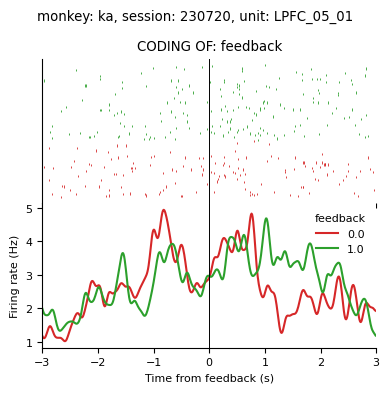

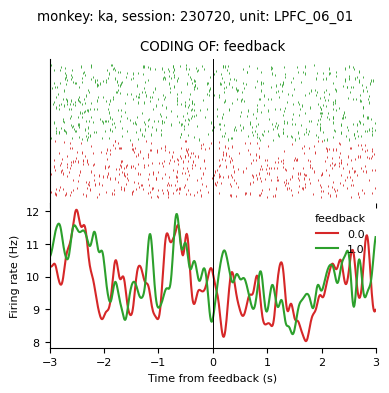

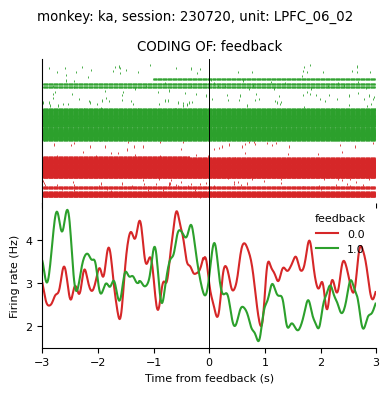

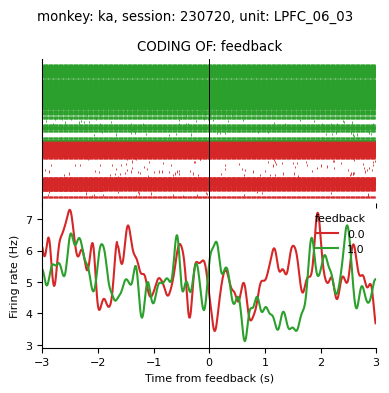

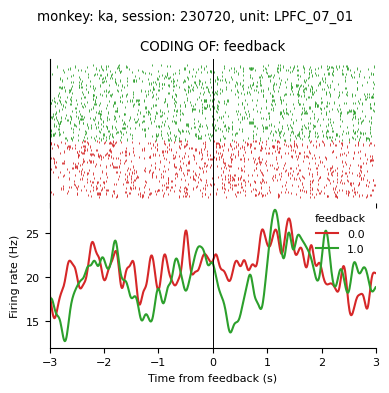

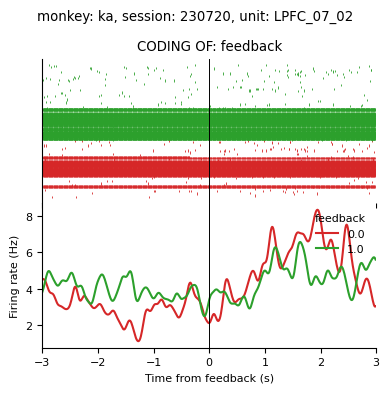

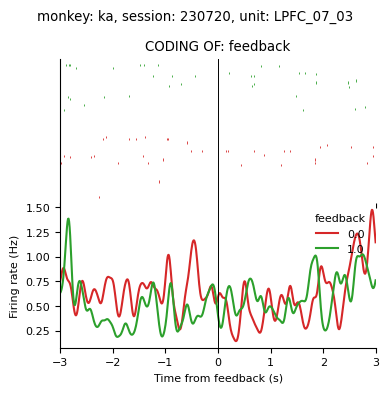

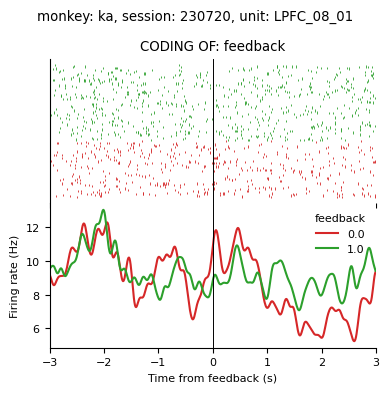

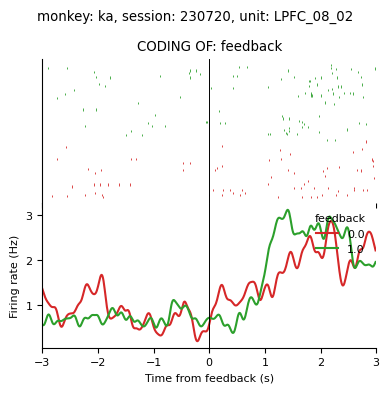

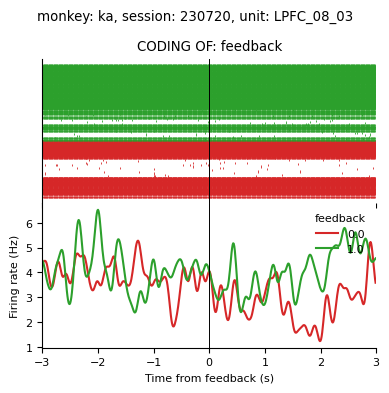

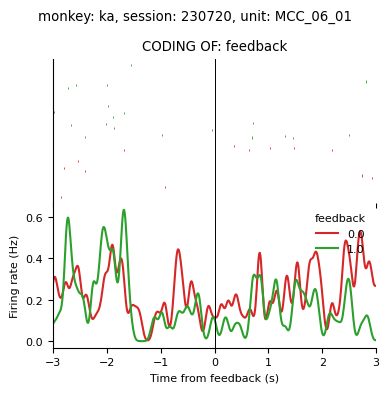

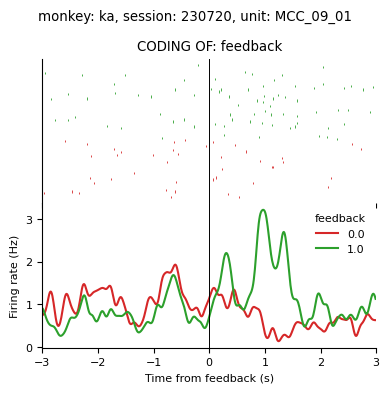

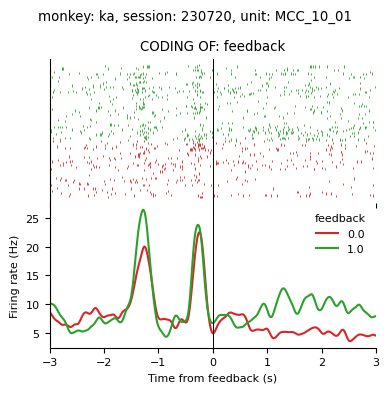

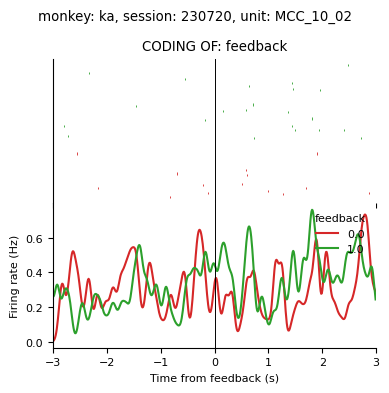

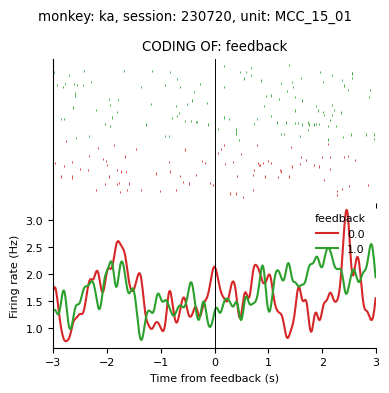

In [7]:
#unit_name = neural_data_proc.unit.data[-11]  # get the first unit as an example
#unit_name = 'MCC_07_02'  # get the first unit as an example

for unit_name in neural_data_proc.unit.data:

    title = f'monkey: {neural_data_proc.coords["monkey"].data[0]}, session: {neural_data_proc.coords["session"].data[0]}, unit: {unit_name}'
    fig, axs = plot_rates_with_raster(
        neural_data_proc, 
        unit_name, 
        mode='centering',
        #n_extra_trials=n_extra_trials, 
        title=title,
        time_window=(-3, 3),
        show_raster=True,
        )
        
    # save the figure in svg, 300 dpi
    '''fig.savefig(
        f'figs/paper_figs/{monkey}_{session}_{unit_name}_{variable_of_interest}_raster_rate.svg',
        dpi=300,
        bbox_inches='tight',
        transparent=True
        )'''
        
    plt.show()
    plt.close()
